# QOSF Task 1: Adding values

Can we find the subsets of a list of numbers that add up to a particular number?
For example, the subsets of $(1,3,6,4,2)$ that add up to 6 are $(1,3,2), (4,2)$ and $(6)$. How can we use Quantum Computing to solve similar problems? In particular, which are the subsets of $(5,7,8,9,1)$ whose sum is $16$?

We take some of the advice given in the task document, and present a hybrid algorithm that uses as few qubits as possible and finds the desired subsets with high probability. Fortunately for us, Grover's algorithm is suited to this kind of problems, so there is no need to come up with entirely new routines, but rather figure out how to build the specific components of a Grover's Oracle.

Our algorithm assumes the given array is stored classically, in this case in a Python list. A Quantum Register represents the adresses of the QRAM. If a qubit in this register is in the state $0$, then the respective number is not considered in the sum that will be carried out.

First, we import the necessary tools

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import QFT, ZGate
from qiskit.visualization import plot_histogram

## 1. Planning our circuit

We need to know how many qubits we will need for this task.
We want a 5-qubit register that will represent the QRAM. We will also consider a 5-qubit register in which we will store the result of the sum, as well as an additional ancilla qubit.

We can use each of the qubits in the memory register to control whether or not a number in the given vector will be added to the result, which we will do by modifying the Draper Adder just a little bit. In this way, we can create a superposition of all possible basis states to make a superposition of all possible sums!

Finally, our last qubit will be used to change the phase of the 'winning' states to be found by Grover's algorithm.

Since our goal is to find the subsets of the QRAM that generate the desired sum, we will also need a 5-bit Classical Register to measure the memory register.

In [2]:
#Defining our quantum registers
memory = QuantumRegister(5)
result = QuantumRegister(5)
phaser = QuantumRegister(1)

meas = ClassicalRegister(5)

## 2. Fine-tuning our adder

We have the qubits that will control the addition in the result register. Now, we need to craft an oracle that does this operation. What's more important, we can generalize this using a function which we can call according to each case.

Our adder will only focus on the rotation part, so for now let's assume the qubits are already in the Fourier basis.

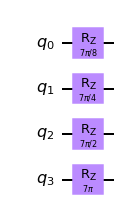

In [3]:
def draper_adder(value, num_qubits):
    circuit = QuantumCircuit(num_qubits)
    
    #value_bin = bin(value)[2:]
    #if num_qubits < len(value_bin):
    #    print(f"Can't add {value} using only {len(qubits)} qubits!")
    #    return None
    for i in range(num_qubits):
        circuit.rz(2 * np.pi * value / (2**(num_qubits-i)), i)

    return circuit.to_gate(label=f' Adder({value})')
    
#Example
circ_example = QuantumCircuit(4)
adder_example = draper_adder(7, 4)

circ_example.append(adder_example, range(4))
circ_example.decompose().draw('mpl')

**Note.** Notice that we could check whether or not it's possible to add a certain value using a number of qubits. However, we have commented that part out. Since adding in the Fourier basis consists of rotating the qubits on the *xy-plane*, it turns out that adding values needing more than the given number of qubits is equivalent to adding it modulo the total amount of states.

_Example._ Using this method to add $40$ (whose binary representation is $101000$) using only 5 qubits (which allow us to represent up to 32 states) will give us the same result than if we had initially added $40 - 32 = 8$ in the Fourier basis.

## 3a. Grover's Reflection Oracle

So, how can Grover's algorithm help us here?
First of all, we need a way to invert the relative phase of the states we're looking for(i.e. the reflective step). This has to happen only to states whose sum is (in this case) $16$.

To do this, we will use a multi-controlled Z-Gate, controlled on the result register and acting on the ancillary qubit. Phase kickback will do the trick for us, changing the relative phase of the whole state in the memory register!

For our Z-Gate to work, we would like for our result register to be in the state $11111$, the binary equivalent of $31$. However, our target states are those in which the result is $16$, whose representation is $10000$. We account for this by shifting the final result, by adding a fixed sum of $31 - 16 = 15$ at the beginning.

After this, we'd like to reset the result register to the state $00000$. The reason for this is that we will be using this circuit repeteadly (remember Grover needs to iterate a certain number of times). One straightforward way to do this is to substract the same sum after the multicontrolled Z-Gate. This equals appyling the inverse circuit of our adder.


**Note.** Because of Qiskit's qubit ordering, we can flip the list of values so that the output matches the one given in the solution file. This detail is not crucial, though.

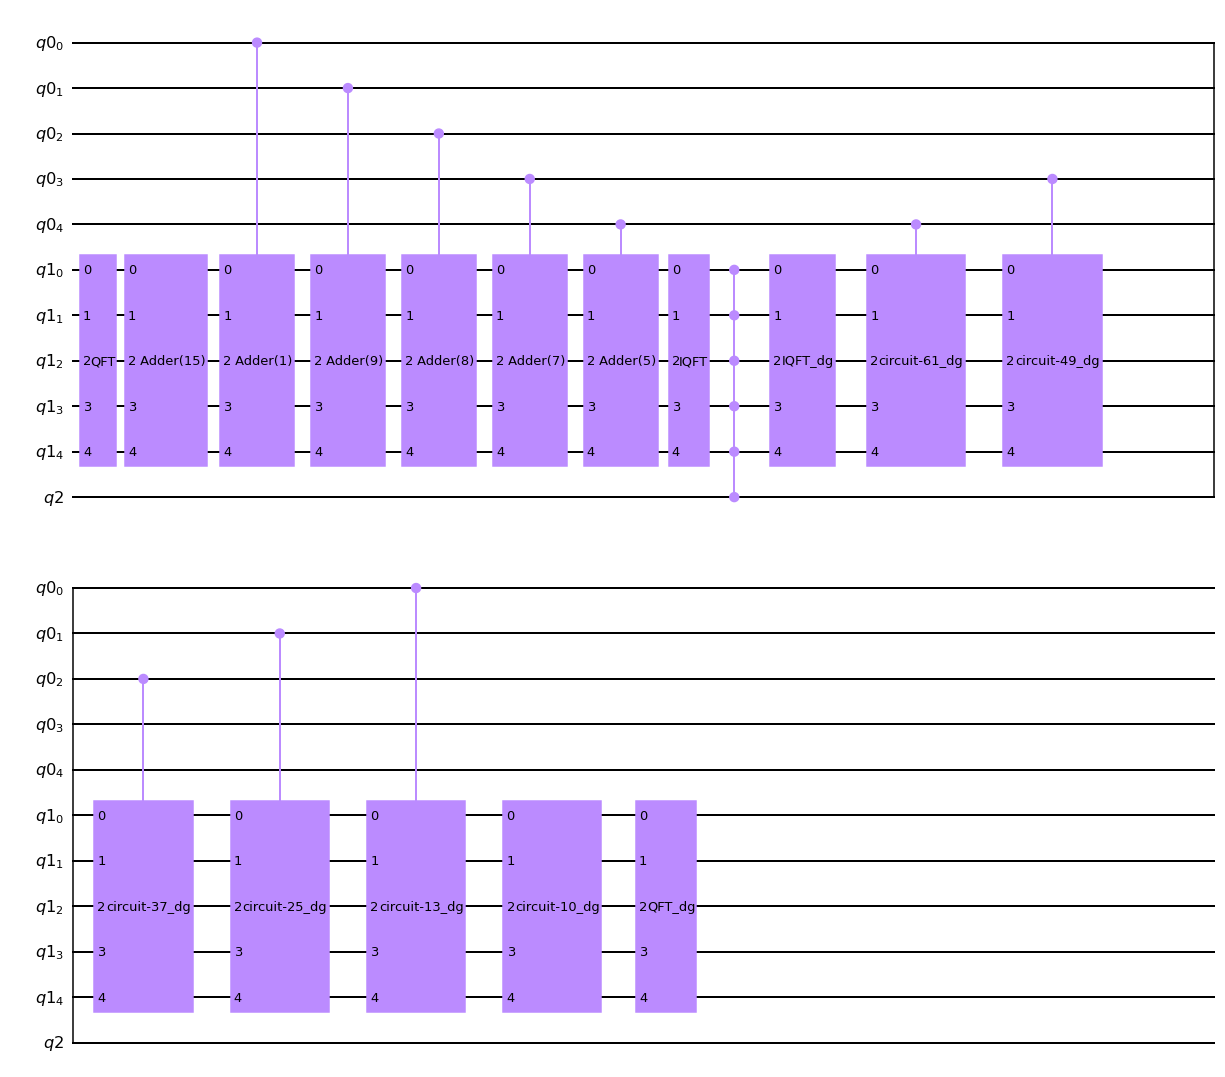

In [4]:

#This is the circuit that uses QFT and Draper Adders to calculate a sum
def controlled_addition(target, values, memReg, resReg, phasReg):
    #Number of qubits in result register
    num_qubits = len(resReg)
    
    #Number of qubits in memory register
    num_values = len(memReg)
    
    #Create the circuit template
    circuit = QuantumCircuit(memReg, resReg, phasReg)
    
    #Put the result state in Fourier basis
    circuit.append(QFT(num_qubits), resReg)
    
    #Add the complement of our target
    #The complement has to shift our target state to the state composed of all 1's,
    # or 2**num_qubits - 1
    complement = 2**num_qubits - 1 - target
    circuit.append(draper_adder(complement, num_qubits), resReg)
    
    #Control the addition of the numbers in the QRAM
    for i in range(num_values):
        circuit.append(draper_adder(values[i], num_qubits).control(1), [memReg[i], *resReg])
        
    #Return the result state to computational basis
    circuit.append(QFT(num_qubits, inverse=True), resReg)

    return circuit

#This circuit combines the adder circuit, a controlled Z-Gate, and resets the result register
def reflection(target, values, memReg, resReg, phasReg):
    #Number of qubits in result register
    num_qubits = len(resReg)
    
    #Create the adder circuit, flipping the list of values to account for Qiskit's ordering
    adder_oracle = controlled_addition(target, values[::-1], memReg, resReg, phasReg)
    
    #Create circuit template
    circuit = QuantumCircuit(memReg, resReg, phasReg)
    circuit.compose(adder_oracle, inplace=True)
    
    #Use a controlled Z-Gate to change the phase of the ancillary qubit
    circuit.append(ZGate().control(num_qubits), [*resReg, *phasReg])
    
    #Finally, we reset the result register, so that its state doesn't interfere with
    # next iterations
    circuit.compose(adder_oracle.inverse(), inplace=True)
    
    return circuit
    
#Particular oracle for this problem
reflector_example = reflection(16, [5,7,8,9,1], memory, result, phaser)
reflector_example.draw('mpl')


## 3b. Grover's Diffuser & Global Phase

Grover's other main element is the *diffuser*, a circuit that, briefly stated, reflects the phase of all but the all-zero state (See this explanation in the [**Qiskit Textbook**](https://qiskit.org/textbook/ch-algorithms/grover.html#Reflection-$U_s$)).

Notice that, up to global phase, this is exactly the same as reflecting the phase of _only_ the zero state. A circuit that does this is much more straightforward, as we only need to worry about one of the total $2^{n}$ cases. We can do this with another multicontrolled Z-Gate.

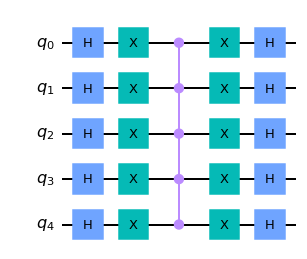

In [5]:
def diffuser(num_qubits):
    circuit = QuantumCircuit(num_qubits)
    
    #The Hadamard gates change the basis from the superposition state to the zero's state.
    circuit.h(range(num_qubits))
    
    #This sends the zero's state to the one's state, which is affected by the MCZ Gate.
    circuit.x(range(num_qubits))
    
    #A multi-controlled Z-Gate flips the phase
    circuit.append(ZGate().control(num_qubits - 1), range(num_qubits))
    
    #The following operations return the quantum state to the superposition state,
    # while preserving the phase flipping
    circuit.x(range(num_qubits))
    circuit.h(range(num_qubits))
    
    return circuit

#Example diffuser used in this algortihm
diffuser_example = diffuser(5)
diffuser_example.draw('mpl')

## 4. Putting everything together

After building each of these components, we can combine them to see the result of our algorithm.

The modularity of this approach will allow us to easily generalize this circuit later on.

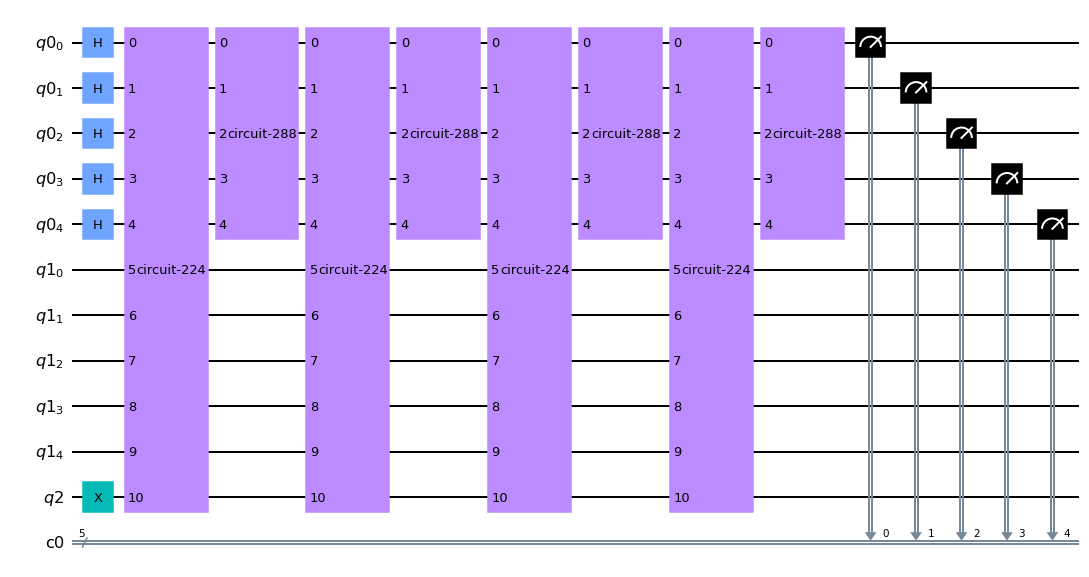

In [6]:
"""
STEP 0. Build a template circuit & set the problem constraints
"""
circuit = QuantumCircuit(memory, result, phaser, meas)

values = [5,7,8,9,1]
target = 16

"""
STEP 1. Creating an equal superposition of all basis states and putting the ancilla qubit on the
        state 1 so that its phase can be flipped with the Z-Gate of the reflector oracle.
"""
#Initialize equal superpostion of all basis states
circuit.h(memory)

#Put our ancilla qubit in the 1 state to flip its phase later
circuit.x(phaser)

"""
STEP 2. A Full grover Oracle
"""
reflector = reflection(target, values, memory, result, phaser)
diffuse = diffuser(len(memory))

#Since we're only measuring the first 5 qubits, there are only 32 possibilities.
# Grover's Algorithm ensures we should find the solutions with approximately 5 oracle iterations.
# However, 4 yields better results, as will be explained later.
for _ in range(4):
    circuit.append(reflector, [*memory, *result, *phaser])
    circuit.append(diffuse, memory)
    

"""
STEP 3. Finding out if our circuit works!
"""

circuit.measure(memory, meas)

#Let's visualize our circuit
circuit.draw('mpl')

## 5. Testing

Once we've built the circuit, let's run it to see if it actually finds the subsets we're looking for. Our Grover's oracle should increase the probabilities of measuring the states we want via amplitude amplification. Notice that we only measured the qubits in the memory register.

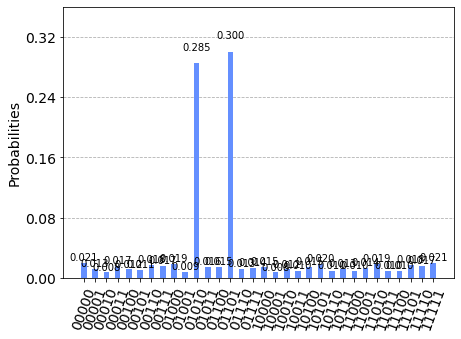

In [7]:
#This function is the standard process to simulate a quantum circuit.
def test_circuit(circuit):
    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circuit)
    
    return counts


#Obtaining & plotting the results from the circuit we built!
counts = test_circuit(circuit)
plot_histogram(counts)

The histogram seems to indicate that Grover's algorithm found two 'winning' states! The subsets found by our algorithm are $01010$ and $01101$. Since our initial list of values was $(5,7,8,9,1)$, this corresponds to the sublists $(7,9)$ and $(7,8,1)$, which happen to be the only two solutions to the challenge!

**Note.** The reason why we chose to repeat Grover's Algorithm 4 times instead of 5, which is closer to $\sqrt{32}$, is because there are two solutions. As explained [**here**](https://qiskit.org/textbook/ch-algorithms/grover.html#Amplitude-Amplification) (at the end of *Step 3*), a good amount of iterations is $\sqrt{\left.32/2\right.} = 4$.

## 6. Solving similar problems
At first, it looks like our algorithm has worked! However, there may be a chance that this big circuit works just by pure luck (though the math behind Grover explains why it should always work). We dare assert this was not the case, and use the general methods built earlier to come up with a general solution to the problem.

The is just one additional step. From the information about the values and the target sum, we have to determine the size of the registers that will be used in the circuit. The memory and phaser registers are straightforward. We only need one ancillary qubit for the phase, and one qubit per element in the list of values given as input.

However, determining the size of the result register needs one more observation. Because adding in the Fourier basis is actually adding modulo a power of two, then we must be careful not to allow congruent (but not equal) sums as part of the target states we've been talking about. Take as an example the example list in the tasks: $(1,3,6,4,2)$. Observe that $1+3+6+4 = 14$. If we use three qubits for the result register (just enough to encode $6$ as $110$), then the state $11110$ will be also 'found' by our algorithm, because $14\equiv 6 \mod 2^{3}$.

A simple way not to worry about this happening is basing the amount of qubits on the maximum sum possible (or the sum we want to find, whichever is bigger). When our list consists only of positive values, then this is the sum of all the elements in the list. We take this assumption for granted, and leave a comment on expanding this algorithm to include negative numbers at the end.

In [8]:
def general_finder(values, target, iterations):
    #Obtaining the size of the registers
    size_qram = len(values)
    
    #We will base the size of the result register on the bigger of the total sum of the values arg or the
    # sum we want to find.
    max_sum = np.amax([np.sum(values), target])
    
    #Once we determine the maximum value, we use their binary expression to know how many qubits will be needed.
    size_result = len(bin(max_sum)[2:])
    
    #Creating the registers
    memory = QuantumRegister(size_qram)
    result = QuantumRegister(size_result)
    phaser = QuantumRegister(1)
    
    #Measurement register is to measure the qram states.
    meas = ClassicalRegister(size_qram)
    
    #Initializing the circuit
    qc = QuantumCircuit(memory, result, phaser, meas)
    
    """
    STEP 1. Creating an equal superposition of all possible sums.
    """
    #Initialize equal superpostion of all possible elements to add
    qc.h(memory)

    #Put our ancilla qubit in the 1 state to flip its phase later
    qc.x(phaser)

    """
    STEP 2. A Full grover Oracle
    """
    reflector = reflection(target, values, memory, result, phaser)
    diffuse = diffuser(size_qram)

    #Grover needs approximately sqrt(2**n) iterations, but we can allow the user to control this.
    for _ in range(iterations):
        qc.append(reflector, [*memory, *result, *phaser])
        qc.append(diffuse, memory)
        
    """
    STEP 3. Finding out if our circuit works!
    """
    qc.measure(memory, meas)
    
    return qc


**Note.** Besides receiving a list of values and a target sum to be found, we have added a third parameter ```iterations``` to the general finder method. This allows the user to control how many times the Grover Oracle will be repeated in the circuit. While we could fix this value to be Grover's famous square root, sometimes it's appropriate to repeat the oracle a smaller number of times, as is the case in the original challenge.

### Experimentation

Let's see how our algorithm performs! We show two more situations. One is the example given in the first task, and the second is a set in which the target is the sum of all the elements. The results show that this is a reliable approach to solve this problem

##### A) Find subsets of $(1,3,6,4,2)$ that add up to $6$

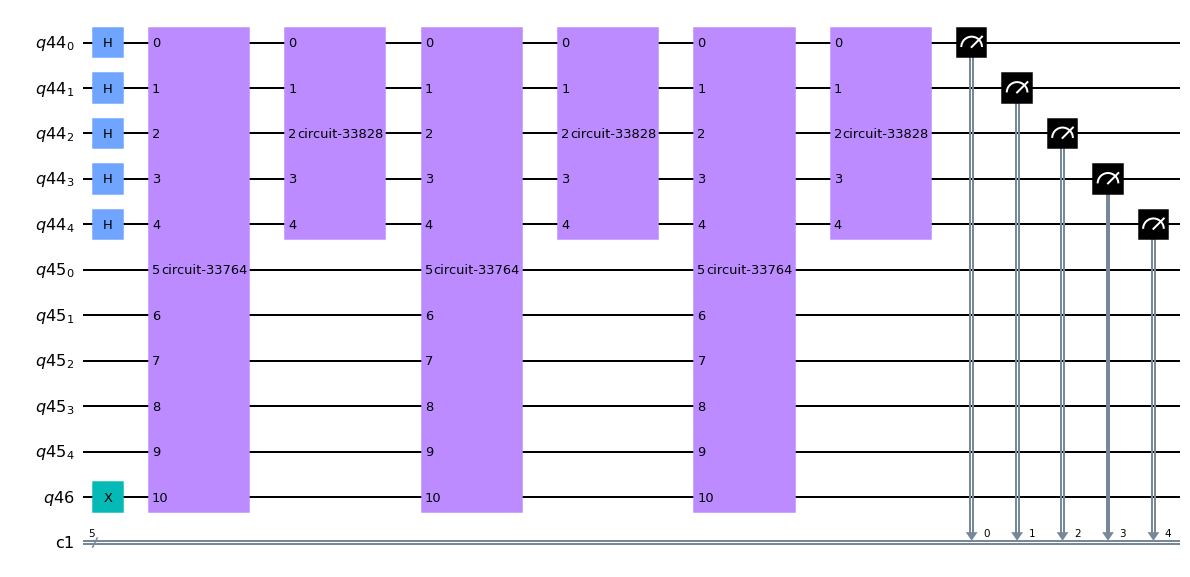

In [9]:
#This is the example case
qc2 = general_finder([1,3,6,4,2], 6, 3)
qc2.draw('mpl')

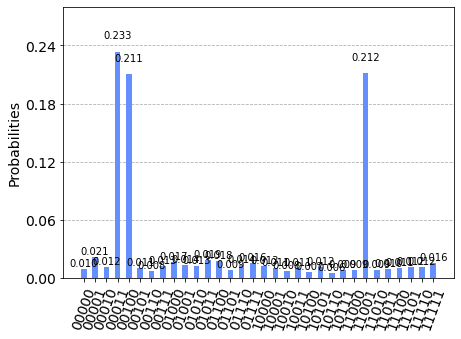

In [10]:
#Observe that the algorithm found the three solutions!
counts_qc2 = test_circuit(qc2)
plot_histogram(counts_qc2)

##### B) Find subsets of $(1,2,3,4)$ that add up to $10$.

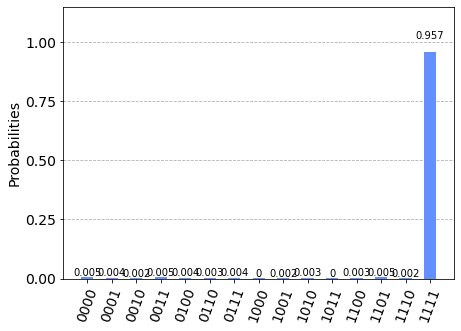

In [11]:
#We omit the circuit in this example.
qc3 = general_finder([1,2,3,4], 10, 3)
counts_qc3 = test_circuit(qc3)
plot_histogram(counts_qc3)

## 7. Classifying the results
Right now, we have to look at the histogram to realize which are the states that we're looking for, and then we need to look back at the list of initial values to figure out the subsets that add up to our target result.

Luckily, we can come up with a simple classifier that does this task for us. In theory, the counts of target states are high, and close to each other, while those of the rest of the states are low. So, we can define a treshold to separate the two groups, which we put at $\frac{3}{5}$ of the highest count. If need be, more complex algorithms like the _k-Nearest Neighbors_ (k-NN) can be used, but we stick to our approach. Getting the corresponding subset from a state in the theoretical qram is easy from here.

In [12]:
"""
SHORT DOCS
values - List of values given to the algorithm.
solutions - Binary strings returned by the experiment.
"""
def translate_from_qram(values, solutions):
    #Subsets is the list where we'll store all possible answers.
    subsets = []
    
    for string in solutions:
        #The value is included in the sublist only if the qubit was measured in the state 1.
        subsets.append(tuple([values[i] for i in range(len(values)) if string[i] == '1']))
        
    return subsets

"""
SHORT DOCS
values - List of values given to the algorithm.
target - Value to be found as the sum of elements in the values arg
iterations - Number of times that the Grover oracle will be repeated
net - Allows the user to choose between bitstrings, or the translated subsets from the values list.
"""
def find_solutions(values, target, iterations, net=False):
    #Run the circuit & evaluate results
    circuit = general_finder(values, target, iterations)
    counts = test_circuit(circuit)
    
    #Create an iterable from the results
    net_counts = [val for val in counts.values()]
    
    #Obtain the maximum counts & define treshold
    top_value = np.amax(net_counts)
    treshold = 3 * top_value / 5
    
    #Get the states whose counts are higher than the treshold
    solutions = [state for (state, count) in counts.items() if count >= treshold]
    
    if net:
        return solutions
    else:
        return translate_from_qram(values, solutions)

print(find_solutions([1,2,3,4], 10, 3))
print(find_solutions([1,3,6,4,2], 6, 3))

[(1, 2, 3, 4)]
[(6,), (4, 2), (1, 3, 2)]


With these additional methods, the solution to the task challenge comes down to the following line of code:

In [13]:
#Voila!
find_solutions([5,7,8,9,1], 16, 4)

[(7, 8, 1), (7, 9)]

## 8. A couple of comments on expanding this algorithm

### Accurately figuring out impossible situations
As of now, this approach has been considering that the sum will be always found in at least one subset of the initial list. However, consider the following scenario:

In [14]:
find_solutions([2, 4, 8, 4, 6, 10], 5, 3)

[(2, 8, 4),
 (4, 8, 4, 10),
 (2,),
 (2, 4, 6),
 (2, 4, 8, 4, 6, 10),
 (4, 8, 10),
 (2, 4, 8, 6),
 (4, 8, 4, 6, 10),
 (6,),
 (2, 8, 4, 6),
 (4, 8, 6, 10),
 (2, 4, 6, 10),
 (2, 8),
 (4, 4, 6, 10),
 (2, 6, 10),
 (2, 4),
 (4, 4),
 (2, 4, 10),
 (4, 6, 10),
 (4, 4, 10),
 (2, 8, 4, 6, 10),
 (2, 4, 4, 6, 10),
 (4, 6, 10),
 (2, 4, 8, 6, 10),
 (6, 10),
 (2, 4, 8),
 (2, 4, 4, 10),
 (2, 4, 8, 4, 6),
 (4, 8, 6),
 (8, 4, 10),
 (2, 8, 4, 10),
 (8, 4, 6, 10),
 (4, 6),
 (2, 4, 6),
 (4, 4, 6),
 (2, 8, 6, 10),
 (),
 (4,),
 (4, 10)]

All of our numbers in the list are even, so there is no way that any of the subsets will add up to $5$. Still, our algorithm has brung up many answers!

The explanation is simple: When there is no solution, there is no difference between 'winner' states and the rest, because there are no 'winner' states. Our treshold then, is useless, because the counts are randomly determined.

A quick add-on to our classifier can help us here. If we add the target sum to the list of values, then Grover will surely find at least one 'winner' state. In the post-processing step, we just need to take it out from the list of results!

In [15]:
"""
SHORT DOCS
values - List of values given to the algorithm.
target - Value to be found as the sum of elements in the values arg
iterations - Number of times that the Grover oracle will be repeated
net - Allows the user to choose between bitstrings, or the translated subsets from the values list.
"""
def solve(values, target, iterations, net=False):
    size = len(values)
    
    #We will apend the target at the end of the values, so that the state 0...01 is a 'winner' state.
    values.append(target)
    
    solutions = find_solutions(values, target, iterations, net=True)
    
    #The predefined winner state has only a 1 at the end, so we get rid of it
    solutions.remove('0' * size + '1')
    
    #Now, we need to take away the last bit of each remaining solution
    sols = [solution[:-1:] for solution in solutions]
    #The resulting list should be empty if no subset has the target sum!
    
    if net:
        return sols
    else:
        #This deletes the sum value, added at the beginning
        values.pop()
        
        return translate_from_qram(values, sols)
    
'''
Our algorithm continues to correctly solve previous problems, but is able to identify unsolvable ones!
'''
print(solve([1,2,3,4], 10, 3))
print(solve([1,3,6,4,2], 6, 3))
print(solve([2, 4, 8, 4, 6, 10], 5, 3))

[(1, 2, 3, 4)]
[(4, 2), (1, 3, 2), (6,)]
[]


### Including negative numbers
We discussed earlier that, when calculating the size of the result register for the circuit that will carry out this algorithm, assuming that all elements in a given list were positive integers really simplified this to calculating the sum of all elements. To see why it's not true with negative numbers, consider again the (modified) example list $(1,3,6,4,2,-8)$. The sum of all the elements is $7$, so in theory, a three-qubit register would be enough. However, we already learned that the relationship between the Fourier basis and modular arithmetic would mess with this and indicate that $(1,3,6,4)$ is a solution.

Is there a way to consider these cases? An implementation of such a circuit is just out of the scope of this notebook. However, we propose a way to attempt so. It may be helpful to consider how negative numbers are implemeted in classical computing: using an additional qubit in the result register to represent the sign of a number. Furthermore, by initially setting the most important qubit to $1$ (the leftmost in Qiskit's ordering), negative numbers turn out to be those whose first digit is $0$ (obtained by substracting some value to the number $10...0$), and positive otherwise. Not only would such an approach be able to consider negative initial values, but negative target sums as well!



###### Jesús Omar Sistos Barrón, 2022